# Introduction to Principal Component Analysis

* This notebook demonstrates inner workings of principal component analysis.
* The notebook does not demonstrate any applications of principal component analysis.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import sys

from pandas import Series
from pandas import DataFrame
from typing import List,Tuple

from pandas import Categorical
from pandas.api.types import CategoricalDtype

from tqdm import tnrange#, tqdm_notebook
from plotnine import *

from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.linalg import eigh

# Local imports
from common import *
from convenience import *

## I. Data generation 

Let us first generate two datasources for the analysis. As usual, we start from white gaussian noise

\begin{align*}
x_1\sim\mathcal{N}(0,1)\\
x_2\sim\mathcal{N}(0,1)\\
x_3\sim\mathcal{N}(0,1)
\end{align*}

and generate three target distributions

\begin{align*}
&\begin{cases}
y_1 = 2 x_1 + x_2 + 1\\
y_2 = 2 x_1 - x_2 - 3
\end{cases} \\
&\begin{cases}
z_1 = 3 x_1\\
z_2 = 5 x_2
\end{cases} \\
&\begin{cases}
u_1 = 3x_1 + 2x_2 + x_3\\
u_2 = 3x_1 - 2x_2\\
u_3 = 2x_2 - x_3\\
\end{cases}
\end{align*}

Note that the first two distributions are two dimensional whereas the last distribution is three dimensional.

### Source data

In [2]:
k = 1000
df = DataFrame({'x1': norm.rvs(size=k), 'x2': norm.rvs(size=k), 'x3': norm.rvs(size=k)})
display(head(df))                   

,x1,x2,x3
0,0.675564,-0.542523,1.203823
1,0.301585,1.923674,-0.754315
2,0.253813,0.516697,0.242943
3,-2.111765,-1.204196,0.176534
4,0.373980,0.860353,-0.635747


### Target distributions

In [3]:
df = (df
      .assign(y1 = lambda df: 2 * df['x1'] + df['x2'] + 1)
      .assign(y2 = lambda df: 2 * df['x1'] -  df['x2'] - 3)
      
      .assign(z1 = lambda df: 3 * df['x1'])
      .assign(z2 = lambda df: 5 * df['x2'])

      .assign(u1 = lambda df: 3 * df['x1'] + 2 * df['x2'] + df['x3'])
      .assign(u2 = lambda df: 3 * df['x1'] - 2 * df['x2'])
      .assign(u3 = lambda df: 2 * df['x2'] - df['x3'])
     )

display(head(df))                   

,x1,x2,x3,y1,y2,z1,z2,u1,u2,u3
0,0.675564,-0.542523,1.203823,1.808605,-1.106349,2.026691,-2.712615,2.145468,3.111738,-2.288869
1,0.301585,1.923674,-0.754315,3.526844,-4.320504,0.904755,9.618371,3.997788,-2.942594,4.601663
2,0.253813,0.516697,0.242943,2.024323,-3.009070,0.761439,2.583483,2.037775,-0.271954,0.790451
3,-2.111765,-1.204196,0.176534,-4.427726,-6.019333,-6.335294,-6.020980,-8.567152,-3.926902,-2.584926
4,0.373980,0.860353,-0.635747,2.608312,-3.112394,1.121939,4.301766,2.206898,-0.598768,2.356453


## II. Data centering and normalisation

The first step in the reconstruction of the affine transformation is data centering and normalisation.
The data centering is essential while data normalisation is optional step and can be skipped. However, this introduces artefacts which can be desirable or not depending on your point of view. 

### Centering

Data centering assures that the mean value for all coordinates is zero and thus it reverses the simple translation part in the affine transformation.


In [4]:
df = (df
      .assign(y1 = lambda df: df['y1'] - df['y1'].mean())
      .assign(y2 = lambda df: df['y2'] - df['y2'].mean())

      .assign(z1 = lambda df: df['z1'] - df['z1'].mean())
      .assign(z2 = lambda df: df['z2'] - df['z2'].mean())

      .assign(u1 = lambda df: df['u1'] - df['u1'].mean())
      .assign(u2 = lambda df: df['u2'] - df['u2'].mean())
      .assign(u3 = lambda df: df['u3'] - df['u3'].mean())
     )

display(head(df))

,x1,x2,x3,y1,y2,z1,z2,u1,u2,u3
0,0.675564,-0.542523,1.203823,0.711551,1.812596,1.893110,-2.752613,2.022853,2.994155,-2.331833
1,0.301585,1.923674,-0.754315,2.429790,-1.401559,0.771173,9.578374,3.875173,-3.060176,4.558700
2,0.253813,0.516697,0.242943,0.927269,-0.090125,0.627858,2.543486,1.915159,-0.389536,0.747487
3,-2.111765,-1.204196,0.176534,-5.524779,-3.100388,-6.468876,-6.060978,-8.689768,-4.044485,-2.627890
4,0.373980,0.860353,-0.635747,1.511259,-0.193449,0.988357,4.261769,2.084282,-0.716350,2.313490


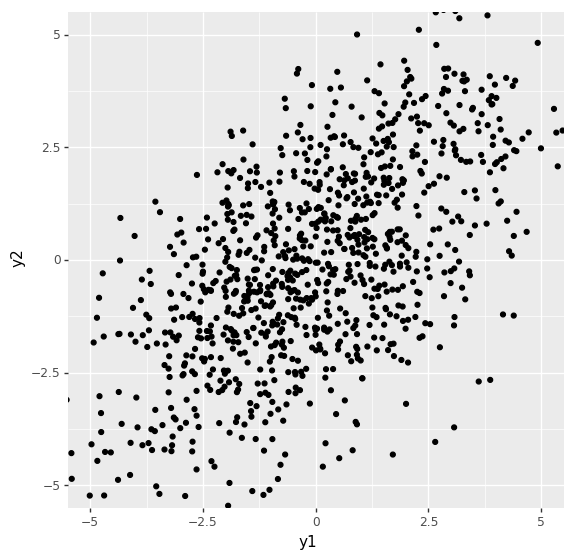

<ggplot: (7545152653)>

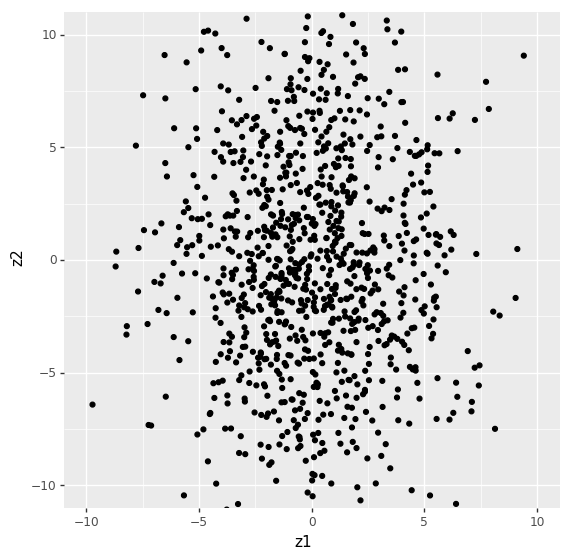

<ggplot: (-9223372029309623159)>

In [5]:
p = ggplot(df)
p = p + geom_point(aes(x = 'y1', y = 'y2'))
p = p + coord_fixed(xlim=(-5, 5), ylim=(-5,5))
display(p)

p = ggplot(df)
p = p + geom_point(aes(x = 'z1', y = 'z2'))
p = p + coord_fixed(xlim=(-10, 10), ylim=(-10,10))
display(p)


### Normalisation

Normalisation means that we scale each coordinate so that the standard deviation becomes one.
As this creates a spacial situation for the distribution $z_1, z_2$ we store the old values into separate comlumns.

In [6]:
df = (df
      .assign(z1u = lambda df: df['z1'])
      .assign(z2u = lambda df: df['z2'])

      .assign(y1 = lambda df: df['y1'] / df['y1'].std())
      .assign(y2 = lambda df: df['y2'] / df['y2'].std())

      .assign(z1 = lambda df: df['z1'] / df['z1'].std())
      .assign(z2 = lambda df: df['z2'] / df['z2'].std())

      .assign(u1 = lambda df: df['u1'] / df['u1'].std())
      .assign(u2 = lambda df: df['u2'] / df['u2'].std())
      .assign(u3 = lambda df: df['u3'] / df['u3'].std())
     )

display(head(df))

,x1,x2,x3,y1,y2,z1,z2,u1,u2,u3,z1u,z2u
0,0.675564,-0.542523,1.203823,0.306803,0.769885,0.602773,-0.530465,0.528206,0.788528,-1.013355,1.893110,-2.752613
1,0.301585,1.923674,-0.754315,1.047666,-0.595301,0.245544,1.845878,1.011883,-0.805915,1.981094,0.771173,9.578374
2,0.253813,0.516697,0.242943,0.399816,-0.038280,0.199912,0.490163,0.500085,-0.102587,0.324839,0.627858,2.543486
3,-2.111765,-1.204196,0.176534,-2.382150,-1.316865,-2.059711,-1.168030,-2.269067,-1.065138,-1.142014,-6.468876,-6.060978
4,0.373980,0.860353,-0.635747,0.651618,-0.082166,0.314696,0.821299,0.544246,-0.188655,1.005384,0.988357,4.261769


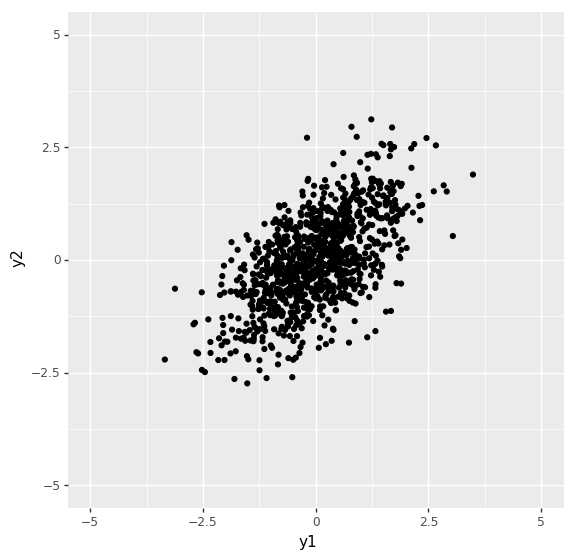

<ggplot: (7545152660)>

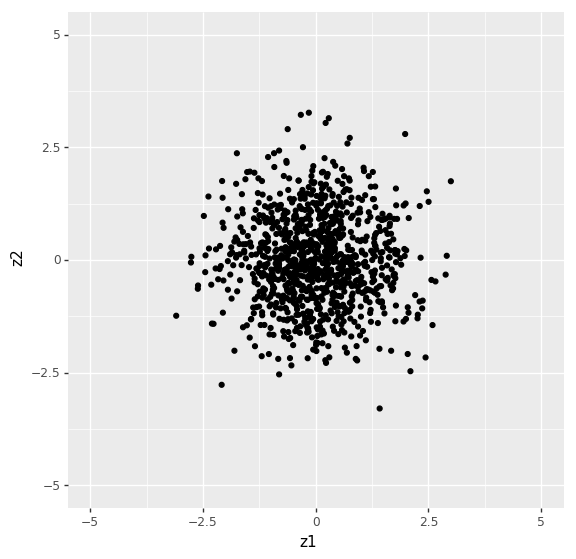

<ggplot: (-9223372029309420814)>

In [7]:
p = ggplot(df)
p = p + geom_point(aes(x = 'y1', y = 'y2'))
p = p + coord_fixed(xlim=(-5, 5), ylim=(-5,5))
display(p)

p = ggplot(df)
p = p + geom_point(aes(x = 'z1', y = 'z2'))
p = p + coord_fixed(xlim=(-5, 5), ylim=(-5,5))
display(p)

**Important:** Note that after normalisation the distribution $z_1,z_2$ looks like a white gaussian noise and thus further reconstruction of the affine transformation becomes impossible. On the other hand, the figure below shows
that we can clearly find the direction of higest variance for unnormalised data.

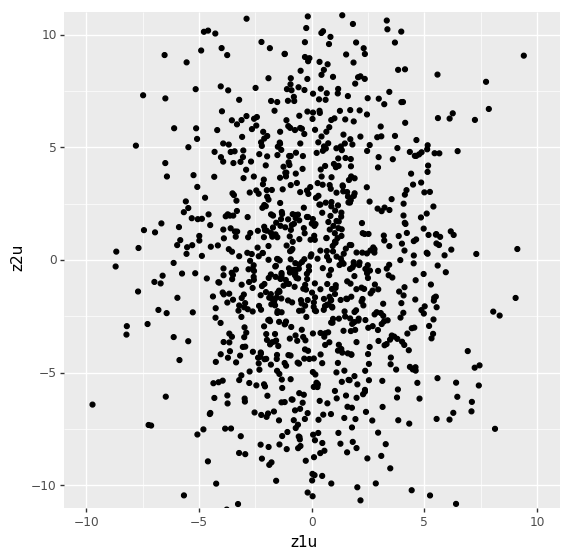

<ggplot: (7545152569)>

In [8]:
p = ggplot(df)
p = p + geom_point(aes(x = 'z1u', y = 'z2u'))
p = p + coord_fixed(xlim=(-10, 10), ylim=(-10,10))
display(p)

However, this aspect can be relavant or not depending of our goal.

* If our aim is to find orthogonal basis $\boldsymbol{b}_1,\ldots,\boldsymbol{b}_n$ for which individual coordinates are uncorrelated then the unnormalised data is already componentwise independent and thus swapping the axis does not do any good. 

* If our aim is to find orthogonal basis $\boldsymbol{b}_1,\ldots,\boldsymbol{b}_n$ such that a subspace $\langle \boldsymbol{b}_1,\ldots,\boldsymbol{b}_k\rangle$ always explains the maximal amount of variation in the data, then normalisation clearly destroys information.

The first goal is more common in the setting where PCA is used as a preprocessing step in a feature extraction, as common machine learning algorithms are insensitive to feature scalings.
The second goal is important for data compaction tasks such as image compression and for algorithms that use distances such as prediction with  K-Nearest Neighbour algorithm Support Vector Machines.
However, the difference is margnal in practice as individual coordinates are rarely uncorrelated.  

## III. Naive search for the first principal component


In [9]:
W = (DataFrame({'alpha': np.linspace(0, 2 * np.pi, 80)})
     .assign(x1 = lambda df: np.sin(df['alpha']))
     .assign(x2 = lambda df: np.cos(df['alpha']))
    )

display(head(W))

,alpha,x1,x2
0,0.000000,0.000000,1.000000
1,0.079534,0.079450,0.996839
2,0.159068,0.158398,0.987375
3,0.238602,0.236344,0.971669
4,0.318136,0.312797,0.949820


Projections of individual datapoints $\boldsymbol{y}_i$ for all different vectors $\boldsymbol{w}_j$:
* Rows correspond to datapoints $\boldsymbol{y}_i$.
* Columns correspond to projection vectors $\boldsymbol{w}_j$.

In [10]:
proj = DataFrame(np.dot(W[['x1','x2']], df[['y1', 'y2']].T).T)
display(head(proj))

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,0.769885,0.791827,0.808763,0.820585,0.827220,0.828624,0.824790,0.815741,0.801534,0.782260,...,0.379596,0.436929,0.491499,0.542962,0.590992,0.635285,0.675563,0.711569,0.743076,0.769885
1,-0.595301,-0.510182,-0.421837,-0.330825,-0.237722,-0.143116,-0.047605,0.048207,0.143714,0.238313,...,-1.136699,-1.101335,-1.059008,-1.009986,-0.954578,-0.893135,-0.826046,-0.753734,-0.676656,-0.595301
2,-0.038280,-0.006394,0.025533,0.057299,0.088702,0.119544,0.149631,0.178772,0.206782,0.233485,...,-0.291254,-0.268360,-0.243770,-0.217638,-0.190130,-0.161420,-0.131690,-0.101127,-0.069924,-0.038280
3,-1.316865,-1.501964,-1.677567,-1.842565,-1.995913,-2.136642,-2.263863,-2.376771,-2.474652,-2.556888,...,0.569569,0.356300,0.140779,-0.075633,-0.291566,-0.505656,-0.716549,-0.922912,-1.123439,-1.316865
4,-0.082166,-0.030135,0.022086,0.074168,0.125781,0.176599,0.226300,0.274570,0.321105,0.365609,...,-0.489608,-0.453279,-0.414085,-0.372273,-0.328107,-0.281867,-0.233844,-0.184344,-0.133677,-0.082166


Lets compute variance for each column

In [11]:
variances = DataFrame(proj.aggregate(np.var, axis = 'rows'), columns = ['variance'])
variances = W.join(variances)
variances = variances.assign(best = lambda df: df['variance'] == df['variance'].max())
head(variances)

,alpha,x1,x2,variance,best
0,0.000000,0.000000,1.000000,1.000000,False
1,0.079534,0.079450,0.996839,1.095928,False
2,0.159068,0.158398,0.987375,1.189434,False
3,0.238602,0.236344,0.971669,1.278157,False
4,0.318136,0.312797,0.949820,1.359856,False


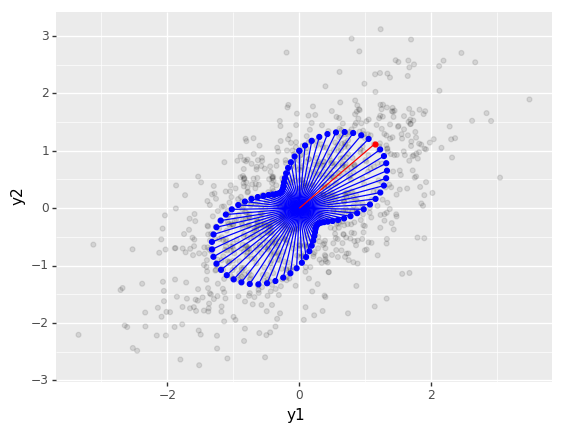

<ggplot: (-9223372029308555881)>

In [13]:
p = ggplot(variances
           .assign(v1 = lambda df: df['variance'] * df['x1'])
           .assign(v2 = lambda df: df['variance'] * df['x2']))
p = p + geom_point(aes(x = 'y1', y = 'y2'), data = df, alpha = 0.1)
p = p + geom_point(aes(x = 'v1', y = 'v2', color = 'best'))
p = p + geom_segment(aes(xend = 'v1', yend = 'v2', color = 'best'), x = 0, y = 0)
p = p + scale_color_manual(breaks = [True, False], values = ['blue', 'red'], guide=False)
p

**Observation:** One would expect to see an ellipsoid here but this is not the case. The eight-shaped curve is the correct outcome. The same is true even if we plot directional standard deviation. 

## IV. Naive search for the principal component in three dimensional space
 

### Search for the first principal component

In three-dimensional space we can do random search or use spherical coordinate system to make a grid of all possible directions. For simplicity we go with random search. 

In [95]:
W = (DataFrame(multivariate_normal(cov=np.identity(3)).rvs(size=100), columns=['u1','u2','u3'])
     .assign(d2 = lambda df: np.sqrt(df['u1']**2 + df['u2']**2 + df['u3']**2))
     .assign(x1 = lambda df: df['u1']/df['d2'])
     .assign(x2 = lambda df: df['u2']/df['d2'])
     .assign(x3 = lambda df: df['u3']/df['d2'])
     [['u1', 'u2', 'u3']]
    )

display(head(W))

,u1,u2,u3
0,0.172199,-0.477333,-2.859693
1,1.076967,1.438389,0.569006
2,-0.545017,-1.338319,0.662711
3,-2.121829,-0.864180,0.889814
4,0.089408,-1.100156,-0.351939


In [96]:
proj = DataFrame(np.dot(W[['u1', 'u2', 'u3']], df[['u1', 'u2', 'u3']].T).T)
display(head(proj))

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,2.612451,1.126465,-2.014744,-2.703890,-0.463639,3.158580,1.261242,0.815407,-1.642355,-0.054317,...,0.047288,-0.275761,-1.490781,0.338923,1.239190,1.777285,-1.444625,-0.058349,1.537095,1.931491
1,-5.106387,1.057800,1.839971,0.312219,0.279878,-6.660137,-1.586220,-3.200528,0.711022,0.735051,...,2.422506,1.069202,3.761993,0.522163,-3.263423,-3.177129,3.087900,0.471016,-1.923542,-4.569265
2,-0.793857,0.575851,0.080013,-0.683396,0.043249,-1.274747,-0.091027,-0.734263,-0.049543,0.134207,...,0.742007,0.072758,0.796992,0.339611,-0.703144,-0.552740,0.663848,0.086123,-0.145876,-0.907243
3,3.383502,-4.625605,1.905349,4.718864,1.370865,3.186738,0.446945,3.709951,4.119440,-1.849343,...,-4.144754,-2.979551,-2.443797,-0.663478,2.262838,0.767690,-0.832507,-1.069253,0.143506,2.999170
4,-2.691319,0.886846,0.622136,-0.097162,-0.097624,-3.148618,-0.850198,-1.770898,-0.236281,0.588125,...,1.420135,0.987235,1.825866,0.143514,-1.598133,-1.422322,1.306942,0.358528,-0.943229,-2.265290


In [97]:
variances = DataFrame(proj.aggregate(np.var, axis = 'rows'), columns = ['variance'])
variances = W.join(variances)
head(variances)

,u1,u2,u3,variance
0,0.172199,-0.477333,-2.859693,6.671672
1,1.076967,1.438389,0.569006,4.363623
2,-0.545017,-1.338319,0.662711,3.660585
3,-2.121829,-0.864180,0.889814,6.725997
4,0.089408,-1.100156,-0.351939,0.867911


In [99]:
w1 = variances.loc[variances['variance'].idxmax(), ['u1', 'u2', 'u3']]
display(w1)

u1    1.299556
u2    2.315416
u3   -1.158379
Name: 29, dtype: float64

### Variance not explained by the first component

Recall that we need to select the second principal componet so that it is ortogonal to the first component. Otherwise we do not recover the second axis of the ellipsoid. For that we need to fix a plane that is orthogonal to $\boldsymbol{w}_1$. That can be done by choosing two non-colinear vectors that are orthogonal to $\boldsymbol{w}_1$. If vectors $\boldsymbol{v}_1$ and $\boldsymbol{v}_2$ have unit length and are otrthogonal to each other, then the related projection coordinates $\xi_1$ and $\xi_2$ is shuch that the length of $\boldsymbol{\xi}$ is the same as the length of $\boldsymbol{x}$ projected to the plane. Such ortohogonal vectors $\boldsymbol{v}_1$ and $\boldsymbol{v}_2$ can be found by the following trick.

In [100]:
# Get orthogonal vectors
v1 = np.array([w1[1], -w1[0], 0])
v2 = np.cross(w1, v1)

# Scale them back to unit length
v1 = v1/np.sqrt(np.dot(v1,v1))
v2 = v2/np.sqrt(np.dot(v2,v2))

Lets project data down to the plane ortogonal to $\boldsymbol{w}_1$ and store corresponding projection coordinates.

,u1,u2,u3
0,0.872036,-0.489441,0.000000
1,-0.195714,-0.348704,-0.916571


,xi1,xi2
0,0.074677,0.550471
1,1.276846,-1.732827
2,0.486303,-0.359839
3,-1.457386,1.862242
4,0.566938,-0.962237


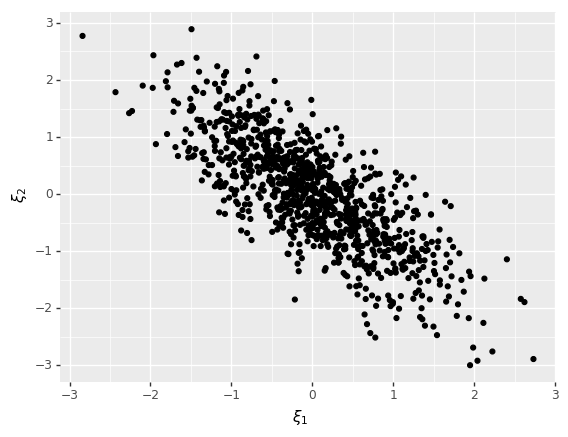

<ggplot: (-9223372029308798660)>

In [101]:
# Projection matrix
P = np.array([v1, v2])
display(DataFrame(P, columns=['u1', 'u2', 'u3']))

# Computation of projection coordinates
xi = DataFrame(np.dot(P, df[['u1', 'u2', 'u3']].T).T, columns=['xi1', 'xi2'])
display(head(xi))
        
# Visualisation        
p = ggplot(xi)
p = p + geom_point(aes(x = 'xi1', y = 'xi2'))
p = p + scale_x_continuous(name=r'$\xi_1$')
p = p + scale_y_continuous(name=r'$\xi_2$')
display(p)

### Search for the second principal component

Again we will use random search to find the second principal component. Note that we can do this either in the original coordinate space $(u_1,u_2,u_3)$ or in the projection space $(\xi_1,\xi_2)$. In principle we get the same result but we need to retranslate projection space solution back to the original space. To avoid this we are doing random search again. 

In [102]:
# Generate xi1 and xi2 coordinates 
W = (DataFrame(multivariate_normal(cov=np.identity(2)).rvs(size=100), columns=['xi1','xi2'])
     .assign(d2 = lambda df: np.sqrt(df['xi1']**2 + df['xi2']**2))
     .assign(xi1 = lambda df: df['xi1']/df['d2'])
     .assign(xi2 = lambda df: df['xi2']/df['d2'])
    )

W = W.join(DataFrame(np.dot(W[['xi1','xi2']], P), columns=['u1', 'u2', 'u3']))
mdisplay([head(W[['xi1', 'xi2']]), head(W[['u1', 'u2', 'u3']])],['Projection coordinates', 'Original coordinates'])

Projection coordinates Original coordinates 
 
 
 xi1 
 xi2 
 
 
 
 
 -0.979170 
 -0.203041 
 
 
 -0.763423 
 0.645898 
 
 
 -0.741263 
 0.671214 
 
 
 -0.712224 
 -0.701952 
 
 
 0.071426 
 -0.997446 
 
 
 
 
 
 u1 
 u2 
 u3 
 
 
 
 
 -0.814134 
 0.550047 
 0.186101 
 
 
 -0.792145 
 0.148424 
 -0.592011 
 
 
 -0.777775 
 0.128750 
 -0.615215 
 
 
 -0.483703 
 0.593365 
 0.643389 
 
 
 0.257500 
 0.312854 
 0.914230

Let check that these direction vectors have unit length and are orthogonal to $\boldsymbol{w}_1$.

In [103]:
mdisplay([head(DataFrame(np.dot(w1, W[['u1', 'u2', 'u3']].T))),
          head(DataFrame((W[['u1', 'u2', 'u3']]**2).apply(sum, axis = 'columns')))],
         ['Ortogonality', 'Length']) 

Ortogonality Length 
 
 
 0 
 
 
 
 
 -5.551115e-17 
 
 
 2.220446e-16 
 
 
 0.000000e+00 
 
 
 0.000000e+00 
 
 
 0.000000e+00 
 
 
 
 
 
 0 
 
 
 
 
 1.0 
 
 
 1.0 
 
 
 1.0 
 
 
 1.0 
 
 
 1.0

Now we can do the actual search as before.

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.184889,0.298538,0.314129,-0.439591,-0.543731,-0.131812,-0.244324,-0.152573,-0.232506,-0.454681,...,0.165538,0.492572,0.149376,0.010572,0.510760,-0.346738,-0.407178,-0.530932,0.285883,-0.542514
1,-0.898416,-2.094004,-2.109578,0.306961,1.819601,1.822117,2.025230,1.865046,-0.713819,2.125687,...,0.969601,-0.677659,-1.858585,1.468514,-0.831803,2.135153,0.113626,1.036325,0.489242,1.187083
2,-0.403111,-0.603674,-0.602008,-0.093767,0.393655,0.584214,0.604296,0.589848,-0.359702,0.542992,...,0.419396,-0.013040,-0.589034,0.524623,-0.059222,0.596045,-0.147270,0.122321,0.304794,0.170346
3,1.048918,2.315422,2.330271,-0.269219,-1.961581,-2.037479,-2.247251,-2.082351,0.848581,-2.323564,...,-1.125999,0.679091,2.075611,-1.662798,0.850206,-2.353414,-0.056301,-1.077948,-0.604045,-1.246404
4,-0.359756,-1.054321,-1.066118,0.271657,1.000273,0.879570,1.006555,0.905516,-0.260511,1.115131,...,0.398320,-0.458341,-0.901589,0.674323,-0.534831,1.087563,0.172880,0.635148,0.141119,0.708122


,xi1,xi2,d2,u1,u2,u3,variance,best
0,-0.979170,-0.203041,0.793727,-0.814134,0.550047,0.186101,0.454211,False
1,-0.763423,0.645898,1.055860,-0.792145,0.148424,-0.592011,1.352116,False
2,-0.741263,0.671214,1.149327,-0.777775,0.128750,-0.615215,1.363775,False
3,-0.712224,-0.701952,1.022714,-0.483703,0.593365,0.643389,0.180391,False
4,0.071426,-0.997446,2.360761,0.257500,0.312854,0.914230,0.958112,False


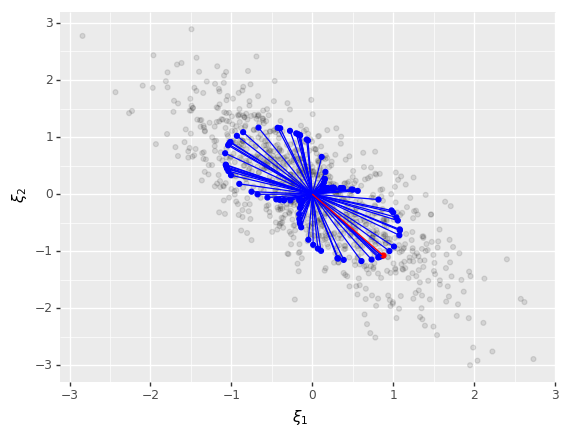

<ggplot: (7547266582)>

In [105]:
proj = DataFrame(np.dot(W[['u1', 'u2', 'u3']], df[['u1', 'u2', 'u3']].T).T)
display(head(proj))

variances = DataFrame(proj.aggregate(np.var, axis = 'rows'), columns = ['variance'])
variances = W.join(variances)
variances = variances.assign(best = lambda df: df['variance'] == df['variance'].max())
display(head(variances))

p = ggplot(variances
           .assign(v1 = lambda df: df['variance'] * df['xi1'])
           .assign(v2 = lambda df: df['variance'] * df['xi2']))
p = p + geom_point(aes(x = 'xi1', y = 'xi2'), data = xi, alpha = 0.1)
p = p + geom_point(aes(x = 'v1', y = 'v2', color = 'best'))
p = p + geom_segment(aes(xend = 'v1', yend = 'v2', color = 'best'), x = 0, y = 0)
p = p + scale_color_manual(breaks = [True, False], values = ['blue', 'red'], guide=False)
p = p + scale_x_continuous(name=r'$\xi_1$')
p = p + scale_y_continuous(name=r'$\xi_2$')
p

As a result we can extract the second principal component. As two non-colinear vectors $\boldsymbol{w}_1$ and $\boldsymbol{w}_2$ uniquely determine the last ortogonal direction $\boldsymbol{w}_3$ we are done.

In [114]:
w2 = variances.loc[variances['best'], ['u1', 'u2', 'u3']]
w3 = np.cross(w1,w2)
w3 = w3/np.sqrt(sum(w3**2))
mdisplay([DataFrame(w1), w2.T, DataFrame(w3).T], ['w1', 'w2', 'w3'])

w1 w2 w3 
 
 
 29 
 
 
 
 
 1.299556 
 
 
 2.315416 
 
 
 -1.158379 
 
 
 
 
 
 21 
 
 
 
 
 0.703077 
 
 
 -0.039394 
 
 
 0.710022 
 
 
 
 
 
 0 
 
 
 
 
 1.0 
 
 
 -1.0 
 
 
 -1.0

## V. Principal components as eigenvectors

As discussed in the lecture the colsed form solution to variance maximisation is given by the eigenvectors of the covariance matrix.
As our data is centered, we can compute covariance matrix directly with matrix operations.

,y1,y2
y1,0.999000,0.605008
y2,0.605008,0.999000


eigenvalues eigenvectors 
 
 
 0 
 
 
 
 
 0.393992 
 
 
 1.604008 
 
 
 
 
 
 PC1 
 PC2 
 
 
 
 
 0.707107 
 -0.707107 
 
 
 -0.707107 
 -0.707107

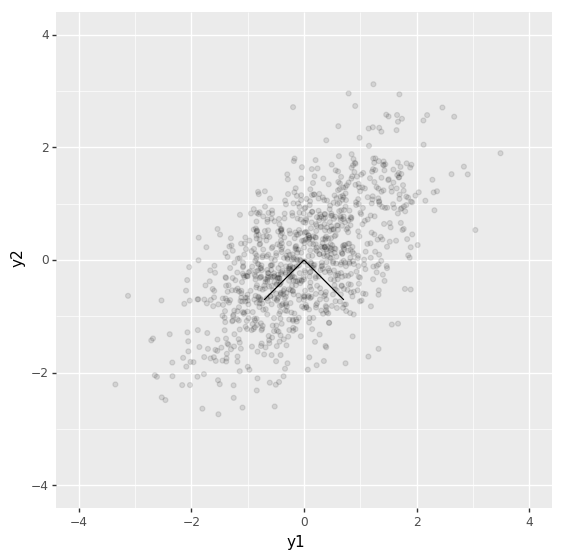

<ggplot: (-9223372029308181749)>

In [141]:
Sigma = df[['y1', 'y2']].T.dot(df[['y1', 'y2']])/len(df)
display(Sigma)

lamb, W = eigh(Sigma)
W = DataFrame(W, columns = ['PC1', 'PC2'])
W.index = ['y1', 'y2']

mdisplay([DataFrame(lamb), W], ['eigenvalues', 'eigenvectors'])

p = ggplot(df)
p = p + geom_point(aes(x = 'y1', y = 'y2'), alpha = 0.1)
p = p + geom_segment(aes(xend = 'y1', yend = 'y2'), data = W.T, x = 0, y = 0)
p = p + coord_fixed(xlim=(-4,4), ylim=(-4,4))

display(p)

## VI. Original transformation and eigenvectors

Note that if we know the original affine transformation $\boldsymbol{y}=A\boldsymbol{x}$, then we can express the covariance matrix  $\Sigma=AA^T$. The eigenvalue transformation $\boldsymbol{z}=W\boldsymbol{y}$ allows lead to diagonal covariance matrix, as

\begin{align*}
\mathbf{\mathrm{Cov}}[z]=W\Sigma W^T=\mathrm{diag}(\boldsymbol{\lambda})
\end{align*}

If we take eigenvectors of length one we get

\begin{align*}
\Sigma=W^T\mathrm{diag}(\boldsymbol{\lambda})W
\end{align*}

from which we know that $\Sigma=S^TS$ where 

\begin{align*}
S=\mathrm{diag}\bigl(\sqrt{\boldsymbol{\lambda}}\bigr)W
\end{align*}

The latter means that we could have obtained the same data distribution by applying the matrix $S$ to white gaussian noise and then do some shift to the data. It also means that $A = SR$ for some matrix $R$ that does rotation or coordinate flipping as $W$ recovers A up to rotations anf flips.

# Homework

## 1.1 Two-dimensional PCA (<font color='red'>2p</font>)

Implement the the PCA algorithm as a function for two-dimensional case. For that do the following steps. Centre the data and find the covariance matrix $\Sigma$. Use `scipy.linalg.eigh` function find eigenvectors of $\Sigma$. Apply the method on the distribution 

\begin{align*}
&\begin{cases}
y_1 = 2 x_1 + x_2 + 1\\
y_2 = 2 x_1 - x_2 - 3
\end{cases} \\
\end{align*}

where $x_1\sim\mathcal{N}(0,1)$ and $x_2\sim\mathcal{N}(0,1)$. Complete the exercise by drawing a blue curve that represent empirical variance in each direction centered to the center of gravity of the data:

* In the tutorial above we draw the variance curve for centered data. Here you must draw the standard variance curve on the original data. As the probing lines for the variance go through the center of the gravity you need to shift the variance curve to the right place.  

As you know the original data transformation you also know the theoretical variance curve. Draw this in red.
Add also empirical center of gravity and the theoretical mean value.
To see how much data is needed to adequate reconstruction of the distribution experiment with differen sample sizes. Interpret results.

### 1.2 Two-dimensional PCA and reconstructability of linear transformation (<font color='red'>1p </font>) 

Use the results form the PCA analysis to invert the affine transformation for $(z_1,z_2)$. That is, find the coordinates of the data given the new origin and new directions of the axes computed by the PCA. Visualise the reconstruction quality by visualising 30 original data points $(x_1,x_2)$ compared to reconstructed data points $(\hat{x}_1,\hat{x}_2)$ that are obtained by projecting data to principal components $\boldsymbol{w}_1$ and $\boldsymbol{w}_2$. How is the result related with impossibility of full reconstruction? 

## 1.3 Two-dimensional PCA and non-gaussian distributions (<font color='red'>2p</font>)

We can apply the PCA even if the data does not come from a multivariate normal distribution. We still get orthogonal directions of maximal variances. Generate data  

\begin{align*}
&\begin{cases}
y_1 = 2 x_1 + x_2 + 1\\
y_2 = 2 x_1 - x_2 - 3
\end{cases} \\
\end{align*}

where 
 * $x_1\sim\mathsf{Uniform}[0,1]$ and $x_2\sim\mathsf{Uniform}[0,1]$ 
 * $x_1\sim \mathsf{Laplace}(0,1)$ and  $x_2\sim \mathsf{Laplace}(0,1)$
 
and apply PCA. Visualise the data and the directions determined by the principal comonents $\boldsymbol{w}_1$ and $\boldsymbol{w}_2$.
Interpret the result. Compute coordinates $(\hat{x}_1,\hat{x}_2)$ by projecting data to principal components $\boldsymbol{w}_1$ and $\boldsymbol{w}_2$ are these coordinates correlated or not? Give an intuitive justification. 

**Hint:** To generate $\mathsf{Laplace}$ distribution you can use [`scipy.stats.laplac`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.laplace.html) and to generate $\mathsf{Uniform}$ distribution you can use [`scipy.stats.uniform`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.uniform.html).

## 1.2 Three-dimensional PCA with a naive search strategy* (<font color='red'>2p</font>)

In the turorial we used random search instead of a regular grid for the probing directions $\boldsymbol{w}$. Use [spherical coordinate system](https://en.wikipedia.org/wiki/Spherical_coordinate_system) to define a regular grid for the search. Note that the grid does not have uniform density. The number of grid points at poles is much larger tan in the equator but this is irrelevant technical detail. 
After you have fount the first component use [polar coordinate system](https://en.wikipedia.org/wiki/Polar_coordinate_system) to seek the other second principal component. Note that the latter is  equivalent to orienting the spherical coordinate system in a way that the first principal component fixes the north-south axis. Implement the search as a function and visualise the result using [3D plotting sublibrary of Matplotlib](https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html). 
